Importamos algunos paquetes

In [1]:
import numpy as np
from scipy.integrate import odeint as odeint_scipy
import matplotlib.pyplot as plt
from tqdm import tqdm

Definimos el sistema y pintamos la trayectoria

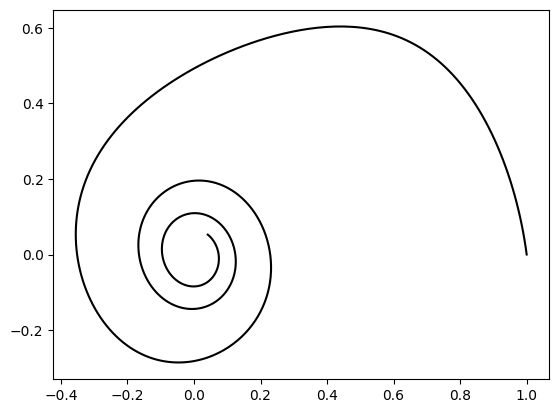

In [2]:
y1_0 = 1
y2_0 = 0
S_0 = [y1_0, y2_0]    # Condiciones iniciales
t_final = 20
data_size = 1000

def sistema(t, S): # S = [y_1, y_2]; A = matriz de parámetros
    y1, y2 = S
    return [- 0.15 * y1 - y2, y1 - 2*y2**3]

t = np.linspace(0, t_final, data_size)
sol = odeint_scipy(sistema, y0 = S_0, t=t, tfirst=True)
plt.plot(sol.T[0], sol.T[1], 'k')

Hacemos el Streamplot

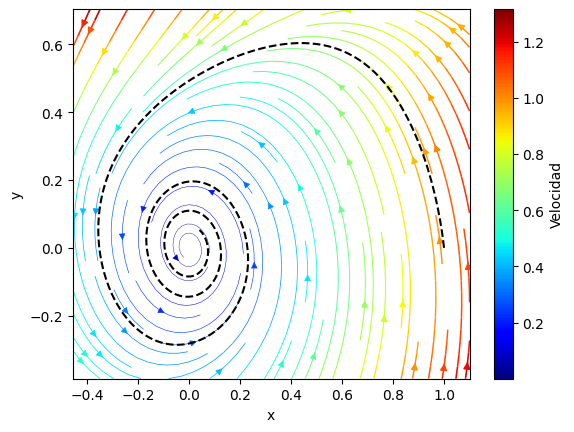

In [3]:
num_points = 1000 # Evaluaciones por cada eje

min_y1 = np.min(sol[:, 0]) - 0.1
min_y2 = np.min(sol[:, 1]) - 0.1
max_y1 = np.max(sol[:, 0]) + 0.1
max_y2 = np.max(sol[:, 1]) + 0.1
max_y1_y2 = np.max(sol) + 0.1
min_y1_y2 = np.min(sol) - 0.1

y1, y2 = np.meshgrid(np.linspace(min_y1, max_y1, num_points), np.linspace(min_y2, max_y2, num_points))
dydt = np.array(sistema(t, [y1, y2]))
dy1 = dydt[0, :, :]
dy2 = dydt[1, :, :] 

# Parámetros del gráfico
speed = np.sqrt(dydt[0, :, :]**2 + dydt[1, :, :]**2)
lw = 2*speed / speed.max()+.5

# Gráfico
fig, ax = plt.subplots()
strm = ax.streamplot(y1, y2, dy1, dy2, color=speed, linewidth=lw/2 ,density=[1,1], cmap=plt.cm.jet)
cbar = fig.colorbar(strm.lines)
cbar.set_label('Velocidad')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(sol.T[0], sol.T[1], 'k--') # Pintamos encima la trayectoria que hemos elegido
plt.ylim(min_y2, max_y2)
plt.savefig("figuras/ejemplo_plano_fases.pdf", bbox_inches = 'tight')
plt.show()

# Definimos una red neuronal para modelar el campo vectorial

Importamos algunas bibliotecas

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torchdiffeq import odeint_adjoint
import matplotlib.pyplot as plt

Definimos algunas funciones auxiliares

In [5]:
def makedirs(dirname): # Función para crear una carpeta
    if not os.path.exists(dirname):
        os.makedirs(dirname)

def get_batch(data_size, batch_size, batch_time, true_y, t):
    """
    batch_y0: conjunto de condiciones iniciales
    batch_t: número de tiempos para las que se calculará la solución con el ODESolve, tomando como puntos iniciales aquellos de batch_y0 para cada caso
    batch_y: conjunto de puntos con los que se calculará la función de pérdida junto con la predicción de la red
    """
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False)) # Lista de índices escogidos al azar sin remplazo para hacer nuestro minibatch. dim = (M, D)
    true_y = torch.from_numpy(true_y)
    batch_y0 = true_y[s] # Si true_y es un tensor, true_y[s] selecciona la s-ésima fila. dim = (T)
    if isinstance(t, np.ndarray):
        t = torch.from_numpy(t)
        
    batch_t = t[:batch_time] # Selecciona los primeros batch_time elementos del vector de tiempos. dim = (T, M, D)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # Selecciona batch_time - 1 elementos para cada condición inicial. dim = (T, M, D)
    
    return batch_y0.float(), batch_t.float(), batch_y.float() # Convertimos a float porque si no la función odeint_adjoint da problemas

makedirs("figuras")


def visualizacion(t, true_y0, true_y, pred_y, func, itr, dir):
    """
    Visualización para el caso sin ruido
    """

    epoca = int(itr)


    min_y1 = np.min(true_y[:, 0]) - 0.1
    min_y2 = np.min(true_y[:, 1]) - 0.1
    max_y1 = np.max(true_y[:, 0]) + 0.1
    max_y2 = np.max(true_y[:, 1]) + 0.1
    max_y1_y2 = np.max(true_y) + 1
    min_y1_y2 = np.min(true_y) - 1

    fig = plt.figure(figsize=(14, 4), facecolor='white')

    # Ajustar el espacio entre subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.4)

    ax_traj = fig.add_subplot(131)
    ax_phase = fig.add_subplot(132)
    ax_vecfield = fig.add_subplot(133)

    # Trayectorias
    x_real = true_y[:, 0]
    y_real = true_y[:, 1]
    ax_traj.set_title("Trayectorias")
    ax_traj.set_xlabel("t")
    ax_traj.set_ylabel("x, y")
    ax_traj.plot(t, x_real, label = 'x(t) real', linestyle='--')
    ax_traj.plot(t, y_real, label = 'y(t) real', linestyle='--')

    pred_y_detached = pred_y.detach()
    """ x_pred = pred_y_detached[:, 0, 0]
    y_pred = pred_y_detached[:, 0, 1] """
    x_pred = pred_y_detached[:, 0]
    y_pred = pred_y_detached[:, 1]
    ax_traj.plot(t, x_pred, label = 'x(t) predicción')
    ax_traj.plot(t, y_pred, label = 'y(t) predicción')
        
    #ax_traj.set_xlim(0, np.max(t))
    ax_traj.set_ylim(min_y1_y2, max_y1_y2)
    ax_traj.legend()

    # Plano de fases aprendido
    pred_completo = odeint_adjoint(func, true_y0, t)
    pred_completo_detached = pred_completo.detach()
    x_pred_completo = pred_completo_detached[:, 0]
    y_pred_completo = pred_completo_detached[:, 1]

    ax_phase.plot(x_pred_completo, y_pred_completo, label = 'Predicción')
    ax_phase.plot(true_y[:, 0], true_y[:, 1], 'k--', label = 'Real')
    ax_phase.set_title(f"Plano de fases. Época {epoca}")
    ax_phase.set_xlim(min_y1, max_y1)
    ax_phase.set_ylim(min_y2, max_y2)
    ax_phase.set_xlabel("x")
    ax_phase.set_ylabel("y")
    ax_phase.legend()


    """# Campo vectorial aprendido
    num_points = 100
    x, y = np.meshgrid(np.linspace(min(true_y[:, 0]) - 1, max(true_y[:, 0]) + 1, num_points), np.linspace(min(true_y[:, 1]) - 1, max(true_y[:, 1]) + 1, num_points))
    dydt = func(0, torch.Tensor(np.stack([x, y], -1).reshape(num_points * num_points, 2))).detach().numpy()

    ax_vecfield.set_title("Campo vectorial aprendido aprendido")
    ax_vecfield.set_xlabel("x")
    ax_vecfield.set_ylabel("y")
    ax_vecfield.streamplot(x, y, dydt[:, 0], dydt[:, 1], color="black") """

    # vector field
    num_points = 100
    x, y = np.meshgrid(np.linspace(min_y1, max_y1, num_points), np.linspace(min_y2, max_y2, num_points))
    dydt = func(0, torch.Tensor(np.stack([x, y], -1).reshape(num_points * num_points, 2))).detach().numpy()
    mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
    dydt = (dydt / mag)
    dydt = dydt.reshape(num_points, num_points, 2)
    ax_vecfield.set_title("Campo de vectores aprendido")
    ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
    ax_vecfield.set_xlabel("x")
    ax_vecfield.set_ylabel("y")

    plt.draw()
    plt.savefig(f'{dir}/{itr}.pdf', bbox_inches = 'tight')
    plt.savefig(f'{dir}/{itr}.png', bbox_inches = 'tight')
    plt.close()

def visualizacion2(t, true_y0, true_y, true_y_desviado, pred_y, func, itr, dir):
    """
    Visualiación para el caso con ruido
    """

    epoca = int(itr*20)

    min_y1 = np.min(true_y[:, 0]) - 0.1
    min_y2 = np.min(true_y[:, 1]) - 0.1
    max_y1 = np.max(true_y[:, 0]) + 0.1
    max_y2 = np.max(true_y[:, 1]) + 0.1
    max_y1_y2 = np.max(true_y) + 1
    min_y1_y2 = np.min(true_y) - 1

    fig = plt.figure(figsize=(14, 4), facecolor='white')

    # Ajustar el espacio entre subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.4)

    ax_traj = fig.add_subplot(131)
    ax_phase = fig.add_subplot(132)
    ax_vecfield = fig.add_subplot(133)

    # Trayectorias
    x_real = true_y[:, 0]
    y_real = true_y[:, 1]
    x_real_desviado = true_y_desviado[:, 0]
    y_real_desviado = true_y_desviado[:, 1]
    ax_traj.set_title("Trayectorias")
    ax_traj.set_xlabel("t")
    ax_traj.set_ylabel("x, y")
    ax_traj.plot(t, x_real, label = 'x(t) real', linestyle='--')
    ax_traj.plot(t, y_real, label = 'y(t) real', linestyle='--')
    ax_traj.scatter(t, x_real_desviado, label = 'Observaciones x', s = 3)
    ax_traj.scatter(t, y_real_desviado, label = 'Observaciones y', s = 3)

    pred_y_detached = pred_y.detach()
    """ x_pred = pred_y_detached[:, 0, 0]
    y_pred = pred_y_detached[:, 0, 1] """
    x_pred = pred_y_detached[:, 0]
    y_pred = pred_y_detached[:, 1]
    ax_traj.plot(t, x_pred, label = 'x(t) predicción')
    ax_traj.plot(t, y_pred, label = 'y(t) predicción')
        
    #ax_traj.set_xlim(0, np.max(t))
    ax_traj.set_ylim(min_y1_y2, max_y1_y2)
    ax_traj.legend()

    # Plano de fases aprendido
    pred_completo = odeint_adjoint(func, true_y0, t)
    pred_completo_detached = pred_completo.detach()
    x_pred_completo = pred_completo_detached[:, 0]
    y_pred_completo = pred_completo_detached[:, 1]

    ax_phase.plot(x_pred_completo, y_pred_completo, label = 'Predicción')
    ax_phase.plot(true_y[:, 0], true_y[:, 1], 'k--', label = 'Real')
    ax_phase.scatter(true_y_desviado[:, 0], true_y_desviado[:, 1], s = 3, color = 'black', label = 'Observaciones')
    ax_phase.set_title(f"Plano de fases. Época {epoca}")
    ax_phase.set_xlim(min_y1, max_y1)
    ax_phase.set_ylim(min_y2, max_y2)
    ax_phase.set_xlabel("x")
    ax_phase.set_ylabel("y")
    ax_phase.legend()


    """# Campo vectorial aprendido
    num_points = 100
    x, y = np.meshgrid(np.linspace(min(true_y[:, 0]) - 1, max(true_y[:, 0]) + 1, num_points), np.linspace(min(true_y[:, 1]) - 1, max(true_y[:, 1]) + 1, num_points))
    dydt = func(0, torch.Tensor(np.stack([x, y], -1).reshape(num_points * num_points, 2))).detach().numpy()

    ax_vecfield.set_title("Campo vectorial aprendido aprendido")
    ax_vecfield.set_xlabel("x")
    ax_vecfield.set_ylabel("y")
    ax_vecfield.streamplot(x, y, dydt[:, 0], dydt[:, 1], color="black") """

    # vector field
    num_points = 100
    x, y = np.meshgrid(np.linspace(min_y1, max_y1, num_points), np.linspace(min_y2, max_y2, num_points))
    dydt = func(0, torch.Tensor(np.stack([x, y], -1).reshape(num_points * num_points, 2))).detach().numpy()
    mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
    dydt = (dydt / mag)
    dydt = dydt.reshape(num_points, num_points, 2)
    ax_vecfield.set_title("Campo de vectores aprendido")
    ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
    ax_vecfield.set_xlabel("x")
    ax_vecfield.set_ylabel("y")

    plt.draw()
    plt.savefig(f'{dir}/{itr}.png', bbox_inches = 'tight')
    plt.savefig(f'{dir}/{itr}.png', bbox_inches = 'tight')
    plt.close()

Definimos nuestra red neuronal

In [6]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 20),  # Capa oculta con 50 neuronas
            nn.Tanh(),         # Función de activación tangente hiperbólica
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 2)
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y) 

## Caso sin ruido

Entrenamos nuestra red neuronal

In [7]:
func_sin_ruido = ODEFunc()

# Parámetro de ejecución
data_size = 500 # Cantidad de puntos de entrenamiento totales
batch_time = 10
batch_size = 20
n_iters = 10000

# Datos de entrenamiento
true_y0 = torch.tensor([y1_0, y2_0]).float()
t = torch.linspace(0, t_final/3, data_size)
true_y = odeint_scipy(sistema, y0 = true_y0.numpy(), t=t, tfirst=True)

optimizer = optim.Adam(func_sin_ruido.parameters(), lr=1e-2)
loss = 1
ii = 0
loss_vector = []
num_imgs = 0



with tqdm(total=n_iters) as pbar:
    for itr in range(1, n_iters + 1):
        ii += 1
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch(data_size, batch_size, batch_time, true_y, t)
        pred_y = odeint_adjoint(func_sin_ruido, batch_y0, batch_t)
        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss_vector.append(loss.detach())
        loss.backward()
        optimizer.step()

        # Actualizar la descripción en tqdm con el valor actualizado de loss
        pbar.set_description(f"Loss: {loss.item():.4f}")
        
        # Actualizar el tqdm para mostrar el progreso
        pbar.update(1)

        
        if itr % 25 == 0:
            num_imgs += 1
            representación = odeint_adjoint(func_sin_ruido, true_y0, t)
            visualizacion(t, true_y0, true_y, representación, func_sin_ruido, num_imgs, 'sin_ruido/imagenes')


# Mantener el gráfico final visible después de completar todas las iteraciones
plt.show()
# ln = 1e-3 -> loss = 0.0004

Loss: 0.0026:   1%|          | 112/10000 [00:27<41:03,  4.01it/s]  


KeyboardInterrupt: 

Hacemos un gif para ver el proceso de entrenamiento

In [10]:
from PIL import Image as Image_PIL
import imageio
from IPython.display import Image


images = []
filenames = []

for i in range(1, num_imgs + 1):
    filename = f'sin_ruido/imagenes/{i}.png' 
    filenames.append(filename) 

for filename in filenames:
    try:
        with Image_PIL.open(filename) as img:
            if img is not None:
                images.append(img.resize((1004, 393)))
            else:
                print(f"Error: {filename} no se pudo cargar como imagen válida.")
    except Exception as e:
        print(f"Error al procesar {filename}: {e}")

# Verificamos los tipos del vector de imágenes
for img in images:
    print(type(img))

imageio.mimsave('movie_sin_ruido.gif', images, duration=0.001)

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>


Mostramos el gif

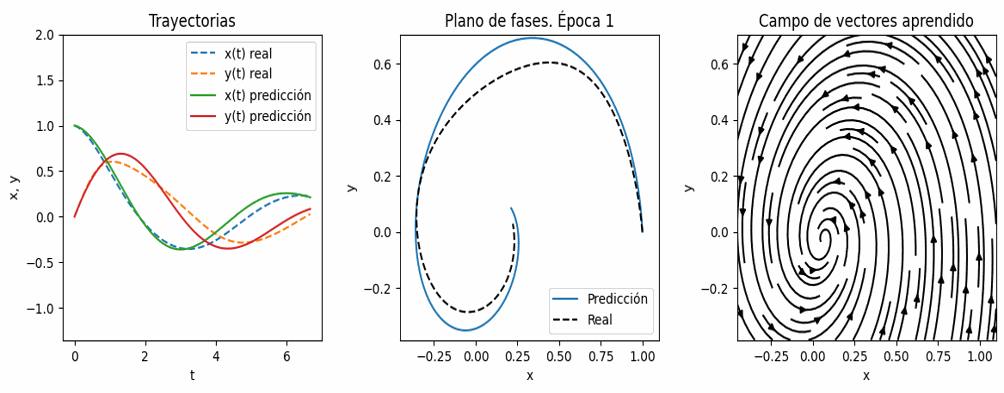

In [11]:
Image(url='movie_sin_ruido.gif') 
display(Image(data=open("movie_sin_ruido.gif",'rb').read(), format='png'))

Hacemos la extrapolación fuera de la región de entrenamiento

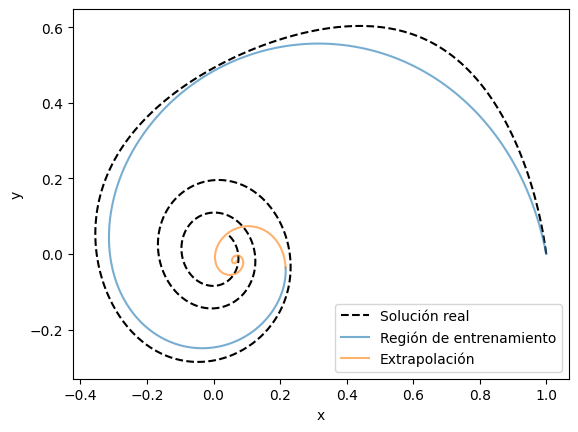

In [12]:
t = torch.linspace(0, t_final/3, data_size)
true_y0 = torch.tensor([y1_0, y2_0]).float()
t_extra = torch.linspace(t_final/3, 20, data_size)
extra_y0 = torch.tensor([y1_0, y2_0]).float()

entrenamiento = odeint_adjoint(func_sin_ruido, true_y0, t)
entrenamiento = entrenamiento.detach()

t_extra = torch.linspace(t_final/3, 20, data_size)
extra_y0 = torch.tensor([entrenamiento[-1, 0], entrenamiento[-1, 1]]).float()


extrapolacion = odeint_adjoint(func_sin_ruido, extra_y0, t_extra)
extrapolacion = extrapolacion.detach()
plt.plot(sol.T[0], sol.T[1], 'k--', alpha = 1, label = 'Solución real')
plt.plot(entrenamiento[:, 0], entrenamiento[:, 1], alpha = 0.6, label = 'Región de entrenamiento')
plt.plot(extrapolacion[:, 0], extrapolacion[:, 1], alpha = 0.6, label = 'Extrapolación')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('sin_ruido/extrapolacion.pdf', bbox_inches = 'tight')
plt.show()

## Caso con ruido

Tomamos menos puntos y añadimos error

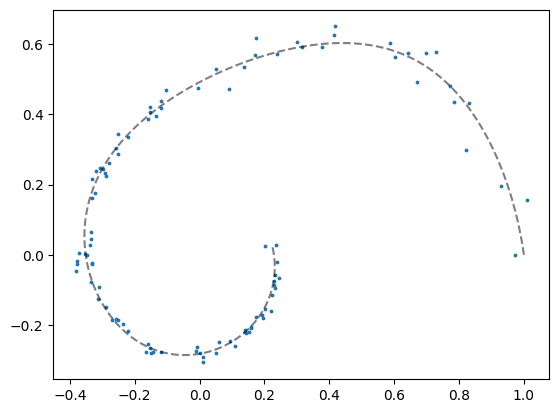

In [13]:
data_size = 1000
puntos_escogidos = 100

np.random.seed(12)

t = np.linspace(0, t_final/3, data_size)
indices_random = np.random.choice(data_size, size=puntos_escogidos, replace=False)
indices_random = np.sort(indices_random)
indices_random[0] = 0 # nos aseguramos de coger la condición inicial

sol = odeint_scipy(sistema, y0 = S_0, t=t, tfirst=True)
puntos_entrenamiento = sol[indices_random, :]
tiempos_entrenamiento = t[indices_random]

porcentaje_error = 0.05

puntos_entrenamiento_desviados = np.random.normal(puntos_entrenamiento, np.abs(puntos_entrenamiento * porcentaje_error), puntos_entrenamiento.shape)


plt.plot(sol.T[0], sol.T[1], 'k--', alpha = 0.5, label = 'Solución real')
plt.scatter(puntos_entrenamiento_desviados[:, 0], puntos_entrenamiento_desviados[:, 1], s = 3)

Entrenamos la red neuronal

In [14]:
func_con_ruido = ODEFunc()

# Parámetro de ejecución
data_size = puntos_escogidos # Cantidad de puntos de entrenamiento totales
batch_time = 100 # IMPORTANTE: si el batch no es completo, el entrenamiento no sale bien
batch_size = 100
n_iters = 2000

# Datos de entrenamiento
true_y0 = torch.tensor([y1_0 + np.random.normal(0, porcentaje_error * y1_0), np.random.normal(0, porcentaje_error * y2_0)]).float()
t = torch.tensor(tiempos_entrenamiento)
true_y_desviado = puntos_entrenamiento_desviados

optimizer = optim.Adam(func_con_ruido.parameters(), lr=1e-2)
loss = 1
ii = 0
loss_vector = []
num_imgs = 0

t_solucion = torch.linspace(0, t_final/5, 500)


with tqdm(total=n_iters) as pbar:
    for itr in range(1, n_iters + 1):
        ii += 1
        optimizer.zero_grad()
        #batch_y0, batch_t, batch_y = get_batch(data_size, batch_size, batch_time, true_y_desviado, t)
        pred_y = odeint_adjoint(func_con_ruido, true_y0, t)
        loss = torch.mean(torch.abs(pred_y - torch.tensor(true_y_desviado)))
        #loss_vector.append(loss.detach())
        loss.backward()
        optimizer.step()

        # Actualizar la descripción en tqdm con el valor actualizado de loss
        pbar.set_description(f"Loss: {loss.item():.4f}")
        
        # Actualizar el tqdm para mostrar el progreso
        pbar.update(1)

        
        if itr % 20 == 0:
            num_imgs += 1
            representación = odeint_adjoint(func_con_ruido, true_y0, t)
            visualizacion2(t, true_y0, puntos_entrenamiento, true_y_desviado, representación, func_con_ruido, num_imgs, 'con_ruido/imagenes')


# Mantener el gráfico final visible después de completar todas las iteraciones
plt.show()

# previo: 0.0103

Loss: 0.0703:   2%|▏         | 49/2000 [01:26<57:42,  1.77s/it]  


KeyboardInterrupt: 

Generamos un gif del entrenamiento

In [15]:
from PIL import Image as Image_PIL
import imageio
from IPython.display import Image


images = []
filenames = []

for i in range(1, num_imgs + 1):
    filename = f'con_ruido/imagenes/{i}.png' 
    filenames.append(filename) 

for filename in filenames:
    try:
        with Image_PIL.open(filename) as img:
            if img is not None:
                images.append(img.resize((1004, 393)))
            else:
                print(f"Error: {filename} no se pudo cargar como imagen válida.")
    except Exception as e:
        print(f"Error al procesar {filename}: {e}")

# Verificamos los tipos del vector de imágenes
for img in images:
    print(type(img))

imageio.mimsave('movie_con_ruido.gif', images, duration=0.001)



<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>


Visualizamos el entrenamiento

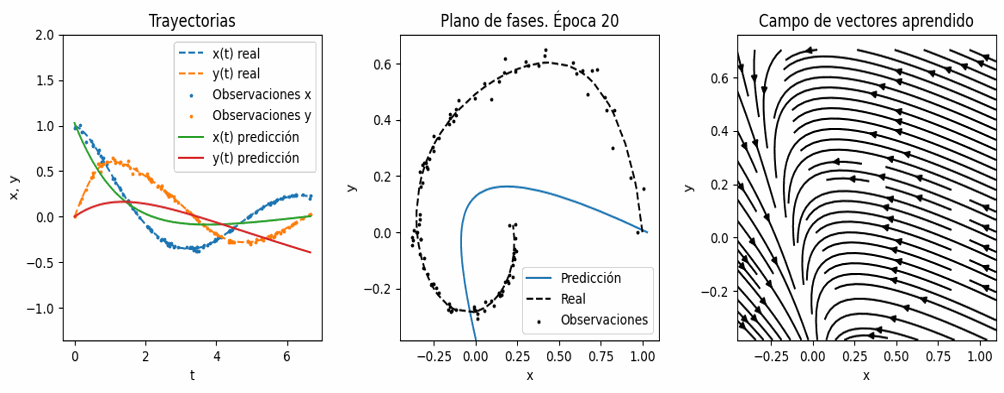

In [16]:
Image(url='movie_con_ruido.gif') 
display(Image(data=open("movie_con_ruido.gif",'rb').read(), format='png'))

In [ ]:
t_final/1.3

19.23076923076923

Extrapolamos fuera de la región de entrenamiento

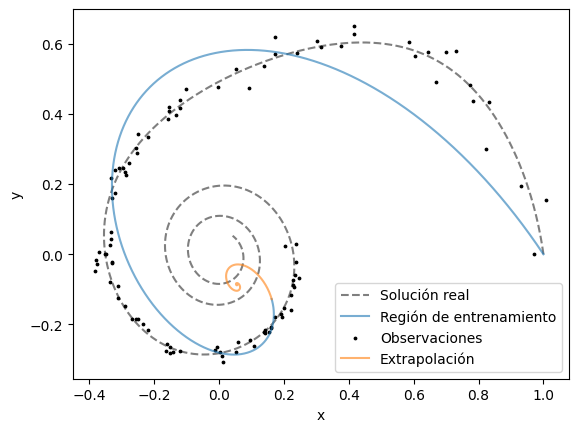

In [17]:
t = torch.linspace(0, t_final/3, 5000)
true_y0 = torch.tensor([y1_0, y2_0]).float()
t_extra = torch.linspace(t_final/3, t_final, data_size)
extra_y0 = torch.tensor([y1_0, y2_0]).float()

entrenamiento = odeint_adjoint(func_con_ruido, true_y0, t)
entrenamiento = entrenamiento.detach()

t_extra = torch.linspace(t_final/3, 20, 500)
extra_y0 = torch.tensor([entrenamiento[-1, 0], entrenamiento[-1, 1]]).float()

t = np.linspace(0, 20, 5000)
sol = odeint_scipy(sistema, y0 = S_0, t=t, tfirst=True)

extrapolacion = odeint_adjoint(func_con_ruido, extra_y0, t_extra)
extrapolacion = extrapolacion.detach()
plt.plot(sol.T[0], sol.T[1], 'k--', alpha = 0.5, label = 'Solución real')
plt.plot(entrenamiento[:, 0], entrenamiento[:, 1], alpha = 0.6, label = 'Región de entrenamiento')
plt.scatter(puntos_entrenamiento_desviados[:, 0], puntos_entrenamiento_desviados[:, 1], s = 3, color = 'black', label = 'Observaciones')
plt.plot(extrapolacion[:, 0], extrapolacion[:, 1], alpha = 0.6, label = 'Extrapolación')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('con_ruido/extrapolacion.pdf', bbox_inches = 'tight')
plt.show()

Guardamos los estados de las redes neuronales

In [18]:
torch.save(func_sin_ruido.state_dict(), 'sin_ruido/func_sin_ruido.pth')
torch.save(func_con_ruido.state_dict(), 'con_ruido/func_con_ruido.pth')

Comprobamos que se han guardado correctamente

In [19]:
model = ODEFunc()  
model.load_state_dict(torch.load('sin_ruido/func_sin_ruido.pth'))
model.eval()

ODEFunc(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [20]:
model = ODEFunc()  
model.load_state_dict(torch.load('con_ruido/func_con_ruido.pth'))
model.eval()

ODEFunc(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)

Guardamos los puntos de entrenamiento por si queremos usarlos luego

In [21]:
np.savetxt('con_ruido/puntos_entrenamiento_desviados.csv', puntos_entrenamiento_desviados, delimiter = ',')
np.savetxt('con_ruido/tiempos_entrenamiento.csv', tiempos_entrenamiento, delimiter = ',')